In [1]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd
import math

from helper_funcs import generate, masked_fill, loss_fn, get_token_batch, encode, decode
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CudaDevice(id=0)]


W1219 10:12:15.071175   37586 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1219 10:12:15.074866   37502 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## Parameter Selection

The Parameters used below are a scaled down version of GPT-2. GPT-2 has 4 different sizes, small, medium, large and xl. This GPT-2 could be considered an extra-small version. Note that these models may not be able to fit into RAM on your device. The exact specifications of the different sized models are shown below:

### GPT-2 Small
- n_embed: 768
- block_size: 1024
- num_heads: 12
- num_layers: 12
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 Medium
- n_embed: 1024
- block_size: 1024
- num_heads: 16
- num_layers: 24
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 Large
- n_embed: 1280
- block_size: 1024
- num_heads: 20
- num_layers: 36
- vocab_size: 50257 (uses Tiktoken vocab)

### GPT-2 XL
- n_embed: 1600
- block_size: 1024
- num_heads: 25
- num_layers: 48
- vocab_size: 50257 (uses Tiktoken vocab)

In [2]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization
#token_id_col='vector_id'
token_id_col='cluster'

rng_key = jax.random.PRNGKey(128)

## Data Preparation

In [3]:
with open('vocab.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

#vocab_size = len(loaded_data['vocab'])
#print(vocab_size)

X = pd.read_parquet("X.parquet")
X

,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster,vector_id
0,1999.076667,8.0,6.9,93.0,0.0,0.0,1017.0,2203,2203,0
1,1952.006667,8.0,6.9,93.0,0.0,0.0,1017.0,2203,2203,0
2,1882.133333,8.0,6.9,93.0,0.0,0.0,1017.0,2203,72,1
3,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
4,1779.133333,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
...,...,...,...,...,...,...,...,...,...,...
110663,3411.043333,22.0,3.1,29.0,320.0,13.0,1016.8,2075,1904,11961
110664,3506.576667,21.0,3.2,31.0,290.0,9.4,1017.0,1904,1904,0
110665,3504.670000,21.0,3.2,31.0,290.0,9.4,1017.0,1904,1904,0
110666,3478.290000,21.0,3.2,31.0,290.0,9.4,1017.0,1904,1904,0


In [4]:
# Test
df_slice = X.iloc[100:224]

v = encode(df_slice, token_id_col=token_id_col)
v

[72,
 72,
 72,
 72,
 1718,
 1718,
 1718,
 1718,
 1073,
 1073,
 1073,
 1073,
 1073,
 1073,
 1073,
 1073,
 2043,
 2043,
 2043,
 2043,
 515,
 909,
 909,
 909,
 594,
 594,
 182,
 182,
 1694,
 1694,
 1694,
 1694,
 459,
 459,
 459,
 459,
 762,
 762,
 762,
 762,
 189,
 189,
 189,
 189,
 1518,
 1518,
 1518,
 1518,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 843,
 1742,
 593,
 593,
 593,
 593,
 593,
 593,
 593,
 593,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1581,
 1752,
 1752,
 1752,
 1752,
 1752,
 1752,
 941,
 941,
 941,
 941,
 1490,
 1490,
 1490,
 1490,
 1692,
 1692,
 1692,
 1692,
 314,
 314,
 314,
 314,
 52,
 52,
 1399,
 2055,
 302,
 302,
 1486,
 1486,
 594,
 594,
 594,
 594]

In [5]:
decode(v, X, token_id_col)

,Power demand,temp,dwpt,rhum,wdir,wspd,pres,next_cluster,vector_id
0,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72.0,0.0
1,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72.0,0.0
2,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72.0,0.0
3,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72.0,0.0
4,1534.386667,9.6,7.0,84.0,0.0,0.0,1018.1,1718.0,0.0
...,...,...,...,...,...,...,...,...,...
119,2861.260000,12.0,11.1,94.0,70.0,9.4,1015.0,1486.0,0.0
120,3630.700000,11.0,10.1,94.0,80.0,11.2,1017.0,594.0,0.0
121,3630.700000,11.0,10.1,94.0,80.0,11.2,1017.0,594.0,0.0
122,3630.700000,11.0,10.1,94.0,80.0,11.2,1017.0,594.0,0.0


In [6]:
vocab_size = X[token_id_col].max()
vocab_size

np.int32(2212)

## Build the Attention Model

In [7]:
from attention_model import *

In [8]:
model = GPT2(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
variables = model.init(rng_key, dummy_x)

In [9]:
out = model.apply(variables, dummy_x)
print(out.shape)

(4, 480, 2212)


## Time Series Generation Pre-Training

In [10]:
index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
max_new_tokens = 24
learning_rate=1e-4

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [11]:
optimizer = optax.adamw(learning_rate=learning_rate)
opt_state = optimizer.init(variables)

In [12]:
epochs = 500
train_ids = X[token_id_col].to_numpy()
losses = []

pbar = tqdm(range(epochs))
for step in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = get_token_batch(train_ids, subkey, batch_size, block_size)

    loss, grads = value_and_grad(loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        yb
    )
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)

    if math.isnan(loss):
        break

    losses.append(loss)
    
    pbar.set_description(f"Epoch: {step}, Loss: {loss :.4f}")

# Save model
model_file = {
    "epochs": epochs,
    "epoch": step,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
}

with open('model.pickle', 'wb') as f:
    pickle.dump(model_file, f)

Epoch: 1, Loss: 8.1286:   0%|          | 2/500 [00:11<48:35,  5.85s/it]  


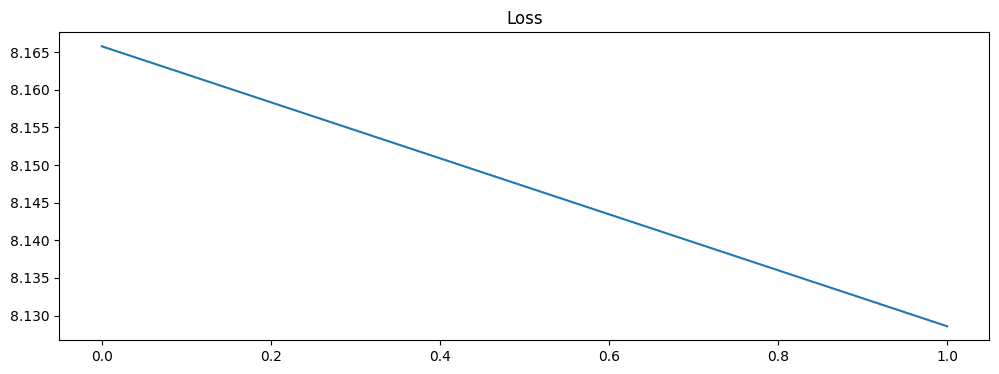

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [14]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens+1:t+max_new_tokens+max_new_tokens+1].reset_index()
x = [encode(X_test, token_id_col)]
index_seq = jnp.array(x)

print(index_seq.shape)
print(index_seq)

(1, 480)
[[1490 1490 1490 2094 2094  515  515 1486 1486 1486 1486  921  921  921
   921  921  921  921  921 1321 1321 1321 1321 2116 2116 2116 2116  811
   811 2116 2116 1945 1945 1945 1945  560  560  560  560 1030 1030 1030
  1030  525  525  525  525  560  560  560  560 1508 1508 1508 1508  276
   276  276  276  821  821  821  821   78 2055 2055 2055  980  351  351
   351    2    2    2    2 1278 1278 1278 1278 1758 1758 1758 1758 1758
  1758 1758 1758  550  550  550  550 1350 1350 1350 1350  550  550  550
   550 2159 1088 1088 1088  248  248  248  248  255 2052 2052 2052  909
   909   41   41 1526 1526 1526 1526 1321 1321 1321 1321 1508 1508 1508
  1508  816  816  816  816  996  996  996  996  703  703  703  703  703
   703  703  703 1097 1097 1097 1097 1181 1181 1181 1181 1117 1117 1117
  1041 1697 1697 1697 1697 1697 1697 1697  351 1969 1969 1969 1969 1969
  1969 1969 1969 1278 1278 1278 1278 1452 1452 1452 1452  550  550  550
   550  550  550  550  550  427  427  427  427  427  42

In [15]:
rng_key, subkey = jax.random.split(rng_key)
generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
generated_indices = list(np.array(generated_indices[0]))
Y = decode(generated_indices, X, token_id_col)

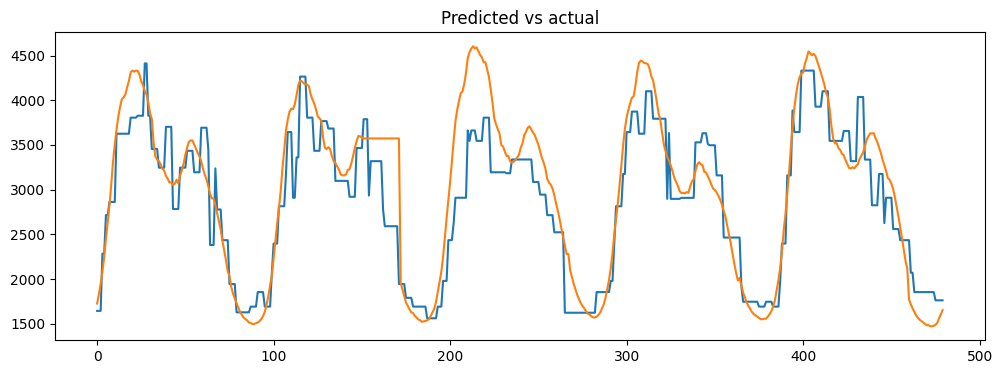

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(Y.index, Y['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.show()